# 3. Проведение расчётов и исследований



In [107]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

## Загрузка обработанных данных

In [108]:
data = pd.read_csv(r"content/processed_data.csv")
data.head()

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,аик,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,аик_с_переливанием_крови
0,нет,Стадия C1-C2,67,1,1,1,1,1,0,0,...,0,1,150.0,0.0,0.0,200.0,830.0,1200.0,900.0,False
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,1,4,235.0,143.0,48.0,600.0,640.0,900.0,800.0,True
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,0,1,210.0,0.0,0.0,250.0,0.0,1800.0,500.0,False
3,нет,Стадия C1-C2,62,1,1,0,1,1,1,0,...,1,3,210.0,71.0,43.0,500.0,1283.0,1700.0,1700.0,True
4,есть,Стадия C1-C2,55,1,1,1,1,1,0,0,...,1,3,265.0,116.0,74.0,500.0,1560.0,1800.0,1300.0,True


## 3.1 Посчитать процент пациентов с хроническими заболеваниям (сахарный диабет, гипертония, хроническая болезнь почек) для групп “есть ОПП/нет ОПП”

In [109]:
def count_percentage(category: str, temp_df: pd.DataFrame):
    '''
        category - название колонки, процент которой будет вычисляться
        temp_df - временный датасет только с двумся колонками: развитие_опп, одина из ['сахарный_диабет', 'гб', 'наличие_хбп']
    '''

    # преобразование датасета, чтобы остались только те, у кого есть хроническое заболевание
    temp_df[category] = temp_df[category].apply(lambda x: 1 if x == 1 else np.NaN)
    temp_df = temp_df.dropna(axis=0)

    # подсчёт количества пациентов, которые имеют/не имеют ОПП
    data = temp_df.groupby(['развитие_опп']).agg({category: 'count'})

    # высчитывание процента пациентов, которые имеют/не имеют ОПП
    answer = [category]
    summ = sum(list(data[category]))
    for en, j in enumerate(data[category]):
        answer.append(f'{list(data[category].index)[en]} ОПП - {round(j / summ * 100, 2)}%')

    '''
        возвращаем список, который содержит следующую информацию:
        answer[0] - название хронической болезни
        answer[1] - процент пациентов, которые болеют хронически и имеют ОПП
        answer[2] - процент пациентов, которые болеют хронически, но не имеют ОПП
    '''
    return answer


warnings.filterwarnings('ignore')
data['наличие_хбп'] = data['хбп'].apply(lambda x: 0 if x == 'Пациенты без ХБП' else 1)

# цикл по всем необходимым хроническим болезням
for categ in ['сахарный_диабет', 'гб', 'наличие_хбп']:
    ans = count_percentage(categ, data[[categ, 'развитие_опп']])
    print(ans[0])
    print(ans[1], ans[2], sep='\n')
    print()


сахарный_диабет
есть ОПП - 69.49%
нет ОПП - 30.51%

гб
есть ОПП - 61.9%
нет ОПП - 38.1%

наличие_хбп
есть ОПП - 65.69%
нет ОПП - 34.31%



## 3.2 Ввести новый фактор (описать и обосновать выбор фактора и его значений) на основе столбца “Индекс массы тела”.  Посчитать количество пациентов, имеющих проблемы с сердцем (выбор перечня проблем должен быть описан и обоснован) для каждой группы. Сделать вывод

Для столбца "Индекс массы тела" был введен новый фактор "имт_группа". Этот параметр выбран в соответствии с рекомендациями Всемирной организации здравоохранения (ВОЗ) и базируется на следующей интерпретации значений ИМТ[2]:

|Индекс массы тела | Соответствие между массой человека и его ростом|
| ----------- | ----------- |
|16 и менее|	Выраженный дефицит массы тела|
|16—18,5|	Недостаточная (дефицит) масса тела|
|18,5—25|	Норма|
|25—30|	Избыточная масса тела (предожирение)|
|30—35|	Ожирение 1 степени|
|35—40|	Ожирение 2 степени|
|40 и более|	Ожирение 3 степени|

(ссылка на статью в Википедии - https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BC%D0%B0%D1%81%D1%81%D1%8B_%D1%82%D0%B5%D0%BB%D0%B0).

In [110]:
def _bmi_categorizer(bmi: float) -> str:
    if bmi <= 16.0:
        return "Выраженный дефицит массы тела"
    if bmi < 18.5:
        return "Недостаточная (дефицит) масса тела"
    if bmi < 25:
        return "Норма"
    if bmi < 30:
        return "Избыточная масса тела (предожирение)"
    if bmi < 35:
        return "Ожирение 1 степени"
    if bmi < 40:
        return "Ожирение 2 степени"
    return "Ожирение 3 степени"


data['имт_группа'] = data['имт'].apply(_bmi_categorizer).astype(str)
data['имт_группа'].head(5)

0                      Ожирение 1 степени
1    Избыточная масса тела (предожирение)
2                      Ожирение 1 степени
3                      Ожирение 1 степени
4                      Ожирение 1 степени
Name: имт_группа, dtype: object

Перечень сердечных проблемы:
> 1. **гб (Гипортоническая болезнь)** - патология сердца и сосудов, проявляющаяся повышением артериального давления
> 2. **стенокардия** - это болевой синдром в грудной клетке, одно из проявлений ишемической болезни сердца (ИБС)
> 3. **инфаркт_миокарда** - серде́чный при́ступ возникает из-за полной или частичной блокировки артерии, питающей сердце
> 4. **мерцательная_аритмия** - нарушение сердечного ритма, характеризующееся хаотическим, нерегулярным сокращением миокарда
> 5. **желудочковая_экстрасистолия** - нарушение сердечного ритма, характеризующееся хаотическим, нерегулярным сокращением миокарда предсердий
> 6. **а-в_блокада** - частичное или полное прерывание проведения импульса от предсердий к желудочкам. Наиболее частой причиной является идиопатический фиброз или склероз проводящей системы сердца.
> 7. **блокада_ножек_пучка_гиса** - нарушение внутрисердечной проводимости, характеризующееся замедлением или полным прекращением проведения импульсов возбуждения по одной или нескольким ветвям пучка Гиса
> 8. **хсн** (хроническая сердечная недостаточность) - Когда сердце не обеспечивает достаточное кровоснабжение организма, это вызывает отеки и кислородное голодание тканей и внутренних органов.
> 9. **нк** (недостаточность кровообращения) - синдром, вызванный декомпенсированным нарушением функции миокарда (мышечная ткань сердечного типа)
> 10. **аик** (наличие аппарата искусственного кровообращения) - когда серце уже не справляется со своими функциями

In [111]:
heart_problem_columns = [
    "гб",
    "стенокардия",
    "инфаркт_миокарда",
    "мерцательная_аритмия",
    "желудочковая_экстрасистолия",
    "а-в_блокада",
    "блокада_ножек_пучка_гиса",
    "хсн",
    "нк",
    "аик",
]

In [112]:
data["имеет_сердечные_проблемы"] = data[heart_problem_columns].any(axis=1)
bpi_grouped_data = data.groupby(["имт_группа", "имеет_сердечные_проблемы"]).size()
bpi_grouped_data

имт_группа                            имеет_сердечные_проблемы
Избыточная масса тела (предожирение)  True                        109
Норма                                 True                         18
Ожирение 1 степени                    True                         56
Ожирение 2 степени                    True                          3
dtype: int64

Вывод: все пациенты имеют сердечные проблемы так или иначе

## 3.3 Исследовать зависимость длительности операции от факта перенесенного в прошлом инфаркта миокарда


$H_{0}$: Нету связи между фактором перенесенным в прошлом инфарктом миокарда и длительности операции\
$H_{1}$: Есть связь между фактором перенесенным в прошлом инфарктом миокарда и длительности операции

### Графический анализ

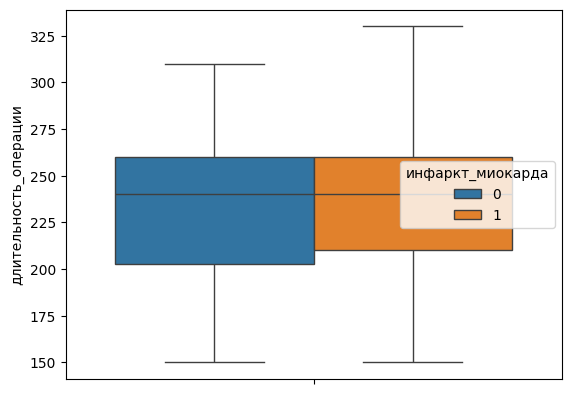

In [113]:
ax = sns.boxplot(y="длительность_операции", hue="инфаркт_миокарда", data=data)

Хотя медиана и интерквартальных размах схожи в обоих "ящиках с усами", у второго графика немного выше первый квартиль и более выражен максимум по сравнению с первой графикой. Это указывает, что в целом распределение данных во втором графике смещено немного вверх, но на основе этого нельзя сделать вывод о зависимости длительности операции от факта перенесенного в прошлом инфаркта миокарда.

### Аналитический анализ

In [114]:
def check_normality(data):
    _, p_value_normality = stats.shapiro(data)
    if p_value_normality <= 0.05:
        print("Данные распределены ненормально")
    else:
        print("Данные распределены нормально")

check_normality(data['длительность_операции'])

Данные распределены ненормально


Шкала у фактора "инфаркт_миокарда" бинарный (номинальный), шкала у отклика "длительность_операции" количественный (ненормальная), поэтому используем **U-критерий Манна-Уитни**

In [115]:
group1 = data[data["инфаркт_миокарда"] == 0]["длительность_операции"]
group2 = data[data["инфаркт_миокарда"] == 1]["длительность_операции"]

cor, pvalue = stats.mannwhitneyu(group1, group2)
round(pvalue, 2)

0.97

При таком уровне значимости, можно сказать что нету связи между перенесенным в прошлом инфарктом миокарда и длительность операции

## 3.4 Верно ли, что у пациентов с ИМТ выше нормы будет повышенный уровень холестерина?


Согласно ВОЗ, избыточная масса тела начинается с 25 ИМТ

|Индекс массы тела | Соответствие между массой человека и его ростом|
| ----------- | ----------- |
|18,5—25|	Норма|
|25—30|	Избыточная масса тела (предожирение)|
|30—35|	Ожирение 1 степени|
|35—40|	Ожирение 2 степени|
|40 и более|	Ожирение 3 степени|

In [116]:
high_imt = data[data["имт"] >= 25]
low_imt = data[data["имт"] < 25]

print(f'ИМТ ниже нормы - уровень холестерина {round(low_imt["холестерин"].mean(), 2)}')
print(f'ИМТ выше нормы -  уровень холестерина {round(high_imt["холестерин"].mean(), 2)}')

ИМТ ниже нормы - уровень холестерина 4.93
ИМТ выше нормы -  уровень холестерина 4.84


Предположение о том, что у пациентов с ИМТ выше нормы будет повышенный уровень холестирина оказалось неверным. У пациентов с ИМТ выше нормы уровень холестирина ниже чем у пациентов с ИМТ ниже нормы

## 3.5 Верно ли, что даже без хронических болезней почек с возрастом толщина паренхимы почек уменьшается?

In [117]:
without_chronic_kidney = data[data["хбп"] == "Пациенты без ХБП"][['возраст', 'толщина_паренхимы_почек']]
without_chronic_kidney.head(5)

,возраст,толщина_паренхимы_почек
2,50,17.0
5,60,19.0
11,60,16.0
12,57,15.0
16,40,15.0


In [118]:
def _age_categorizer(age: int) -> str:
    if 10 <= age < 20:
        return "10-20"
    elif 20 <= age < 30:
        return "20-30"
    if 30 <= age < 40:
        return "30-40"
    elif 40 <= age < 50:
        return "40-50"
    elif 50 <= age < 60:
        return "50-60"
    elif 60 <= age < 70:
        return "60-70"
    elif 70 <= age < 80:
        return "70-80"
    elif 80 <= age < 90:
        return "80-90"

without_chronic_kidney['возрастная_группа'] = without_chronic_kidney['возраст'].apply(_age_categorizer)
without_chronic_kidney.head(5)

,возраст,толщина_паренхимы_почек,возрастная_группа
2,50,17.0,50-60
5,60,19.0,60-70
11,60,16.0,60-70
12,57,15.0,50-60
16,40,15.0,40-50


In [119]:
average_thickness_by_age = without_chronic_kidney.groupby("возрастная_группа")["толщина_паренхимы_почек"].mean().round(1)
average_thickness_by_age

возрастная_группа
30-40    16.7
40-50    15.5
50-60    15.4
60-70    15.2
70-80    15.1
Name: толщина_паренхимы_почек, dtype: float64

Утверждение, что с возрастом толщина паренхимы почек уменшаеться, оказалось неверным. 

## 3.6 Проверить адекватность поставленного диагноза по стадии хронической болезни почек (найти параметр, по которому ставится диагноз, использовать данные из внешних источников)

In [120]:
def make_prediction_to_diagnosis(skf):
    # устанавливаем стадию хбп у пациента
    if g1[0] <= skf <= g1[1]:
        return "Стадия C1-C2"
    elif g2[1] < skf < g1[0]:
        return "Стадия C1-С2"
    elif skf <= g2[1]:
        return "Стадия C3"
    return "Пациенты без ХБП"


def check_diagnosis(cols):
    # проверяем адекватность поставлxенного диагноза
    vals = cols.values
    if vals[0] == vals[1]:
        return "Диагноз поставлен правильно"
    return "Диагноз возможно поставлен некорректно"

In [121]:
pred_data = data[['развитие_опп', 'хбп', 'скф_расч']]
pred_data = pred_data[pred_data['развитие_опп'] == 'есть']  # удаляем всех пациентов у которых нет опп

# узнаем примерные рамки параметра скф по поставленной стадии
d = round(pred_data.groupby(['хбп']).agg({'скф_расч': 'describe'})['скф_расч'], 2)
twenty_five = d['25%'].values
mean = d['mean'].values
seventy_five = d['75%'].values

g1 = [twenty_five[0], seventy_five[0]]
g2 = [twenty_five[1], seventy_five[1]]

# делаем колонку предположительного диагноза
pred_data['предположительный_диагноз'] = pred_data['скф_расч'].apply(lambda x: make_prediction_to_diagnosis(x))
# сравниваем колонку преположительного диагноза и хбп.
# Если диагноз подтверждается: Диагноз поставлен правильно
# Иначе: Диагноз возможно поставлен некорректно
pred_data['адекватность_диагноза'] = pred_data[['предположительный_диагноз', 'хбп']].apply(lambda x: check_diagnosis(x), axis=1)

pred_data[['адекватность_диагноза', 'хбп']].head(10)

,адекватность_диагноза,хбп
1,Диагноз возможно поставлен некорректно,Стадия C1-C2
4,Диагноз поставлен правильно,Стадия C1-C2
6,Диагноз возможно поставлен некорректно,Стадия C1-C2
8,Диагноз поставлен правильно,Стадия C1-C2
10,Диагноз поставлен правильно,Стадия C1-C2
13,Диагноз поставлен правильно,Стадия C1-C2
15,Диагноз возможно поставлен некорректно,Стадия C1-C2
16,Диагноз возможно поставлен некорректно,Пациенты без ХБП
17,Диагноз поставлен правильно,Стадия C1-C2
19,Диагноз поставлен правильно,Стадия C1-C2


## 3.7 Исследовать корреляцию между параметрами. Для наиболее сильных корреляций обосновать, имеет ли это реальный смысл или же просто особенность данных

In [122]:
def chi2_counting(first_cat, second_cat):
    # функция для подсчёта корреляции номинальных данных с номинальными

    temp_table = pd.crosstab(data[first_cat], data[second_cat])
    chi_2 = stats.chi2_contingency(temp_table)
    return chi_2.statistic, chi_2.pvalue


def mannwhitneyu_counting(first_cat, second_cat):
    # функция для подсчёта корреляции количественных данных с номинальными

    mn = stats.mannwhitneyu(first_cat, second_cat)
    cor, p_value = mn.statistic, mn.pvalue
    return cor, p_value


def pearsonr_counting(first_cat, second_cat):
    # функция для подсчёта корреляции количественных данных с количественными (с нормальным распределением данных)

    pr = stats.pearsonr(first_cat, second_cat)
    cor, p_value = pr.statistic, pr.pvalue
    return cor, p_value


def spearmanr_counting(first_cat, second_cat):
    # функция для подсчёта корреляции количественных данных с количественными (с ненормальным распределением данных)

    sp = stats.spearmanr(first_cat, second_cat)
    cor, p_value = sp.statistic, sp.pvalue
    return cor, p_value

In [128]:
nominal = [
    "развитие_опп",
    "пол",
    "гб",
    "сахарный_диабет",
    "стенокардия",
    "инфаркт_миокарда",
    "мерцательная_аритмия",
    "желудочковая_экстрасистолия",
    "а-в_блокада",
    "блокада_ножек_пучка_гиса",
    "хсн",
    "нк",
    "ар",
    "аик",
    "хбп",
    "имт_группа",
]

In [130]:
answer = list()

for first_cat, second_cat in itertools.combinations(set(data.columns), 2):
    g1 = data[first_cat]
    g2 = data[second_cat]
    if first_cat in nominal and second_cat in nominal:
        # высчитывание корреляции для номинальные-номинальные
        cor, p_value = chi2_counting(first_cat, second_cat)
        answer.append([first_cat, second_cat, round(cor, 2), round(p_value, 3)])
    elif (
        first_cat in nominal
        and second_cat not in nominal
        or first_cat not in nominal
        and second_cat in nominal
    ):
        # высчитывание корреляции для количественные-номинальные
        try:
            cor, p_value = mannwhitneyu_counting(g1, g2)
            answer.append(
                [first_cat, second_cat, round(cor, 2), round(p_value, 3)]
            )
        except TypeError:
            pass
    else:
        # высчитывание корреляции для количественные-количественные
        if stats.shapiro(g1).pvalue >= 0.05 and stats.shapiro(g2).pvalue >= 0.05:
            # Данные распределены нормально
            cor, p_value = pearsonr_counting(g1, g2)
            answer.append(
                [first_cat, second_cat, round(cor, 2), round(p_value, 3)]
            )
        else:
            # Данные распределены ненормально
            cor, p_value = spearmanr_counting(g1, g2)
            answer.append(
                [first_cat, second_cat, round(cor, 2), round(p_value, 3)]
            )

# фильтруем данные
new_answer = list()
for result in answer:
    if result[-2] != 0 and -1 <= result[-2] <= 1 and result[-1] <= 0.05:
        new_answer.append(result)

answer_df = pd.DataFrame(
    data=sorted(new_answer, key=lambda x: x[-2], reverse=True),
    columns=["Показатель №1", "Показатель №2", "Значение корреляции", "p-уровень"],
)

answer_df.head(5)

,Показатель №1,Показатель №2,Значение корреляции,p-уровень
0,мо,уо,0.99,0.0
1,общ.со2,нсо3,0.98,0.0
2,дд_лж,кдо,0.93,0.0
3,ксо,сд_лж,0.93,0.0
4,время_пережатия_аорты,длительность_аик,0.89,0.0


p-уровень=0:
Утверждение о том, что корреляции получены неслучайно.

**1. Минутный объём сердца (МО) и Ударный объём сердца (УО)**:\
МО полностью зависит от УО по определению.

**2. Общий уровень углекислого газа (Общ.СО2) и бикарбонат (НСО3)**:\
НСО3 состоит из СО2, поэтому это также особенность данных.

**3. Диастолическая дисфункция левого желудочка (ДД_ЛЖ) и Конечный диастолический объём (КДО):**\
Конечный диастолический объём напрямую зависит от диастолической дисфункции левого желудочка по определению. Корреляция в 0.93, а не 1, может объясняться влиянием других факторов, таких как Систолическая дисфункция левого желудочка (СД_ЛЖ).

**4. Конечный систолический объём (КСО) и Систолическая дисфункция левого желудочка (СД_ЛЖ):**\
Та же причина, что и в предыдущем пункте.

**5. Время пережатия аорты и Длительность аортального искусственного кровообращения (Длительность АИК):**\
При пережатии аорты кровь не циркулирует, что требует наличия аппарата искусственного кровообращения. Почему корреляция равна 0.89, а не 1, возможно, объясняется воздействием других факторов.